In [16]:
import os
from IPython.display import clear_output

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.layers import Lambda, Dense, Dropout

# Data Processing

In [17]:
# Data generation options.
num_points = 31
batch_size = 256

x_const = np.linspace(0, 500000, num_points)
x_values = K.constant(batch_size * [list(x_const)])

files = os.listdir('/Users/AbrahamHussain/Desktop/CS-141/ahussain-models/Seperated-Housing-Data/2007ZIPcode/')
f = np.random.choice(files)
df = pd.read_csv('/Users/AbrahamHussain/Desktop/CS-141/ahussain-models/Seperated-Housing-Data/2007ZIPcode/' + f)

df.TotalLandImpValue[df.TotalLandImpValue < 1]  = 1

/Users/AbrahamHussain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
def generate_data(batch_size=batch_size, num_inputs=10):
    x = np.random.uniform(-1, 1, (batch_size, num_inputs))
    y = np.stack([df.TotalLandImpValue.sample(batch_size, replace=True).values] * num_points).T
    
    return x, y

# Custom Layers and Losses

In [19]:
def normalize(yPred, x, min_p=10e-3, max_p=10e3, percent_observed=1):
    '''
    This should be the final layer of the neural net. An activation
    layer should not be used before this function. Generally choose
    so log(min_p) = -log(max_p).
    
    y - The input to the layer; it can take on any real value.
    
    min_p - The minimum probability estimate at any point before
        normalization.
            
    max_p - The maximum probability estimate at any point after
        normalization.
            
    percent_observed - The estimated percentage of values
        contained within the range of the distribution the model is
        training on. This is used to account for the tails of the
        distribution being trimmed off for training purposes.
    '''
    
    # Sigmoid activation to fit input into range (min_p, max_p).
    y = K.sigmoid(yPred) * (max_p - min_p) + min_p
    
    # Normalize y values by the integral.
    integral = K.sum((y[:, 1:] + y[:, :-1]) * (x[:, 1:] - x[:, :-1])  / 2,
                     axis=1, keepdims=True)
    y = percent_observed * y / integral
    
    return y


In [149]:
def log_normal_pdf(x, p, mu, sig):
    x1 = (1 / (x * sig * np.sqrt(2 * np.pi)))
    x2 = np.e**(-(K.log(x) - mu) / (2 * sig**2))
    return (x1 * x2)

In [54]:
def loss_function(yTrue, yPred, x, n=batch_size, p_min=10e-10):
    '''
    yPred - Parameters defining a piecewise linear PDF. The parameters are
            may be thought of as two vectors x and y. x_i will define the
            distance between the ith and (i-1)th points of the piecewise
            linear. y_i will define the value of the ith point. Both x and
            y are normalized; x relative to the minimum and maximum values
            for the distribution and y so that the PDF integrates to some
            constant less than or equal to one. The first value of x is
            assumed to be zero.
            
    yTrue - A sample drawn from the distribution we are trying to predict.
            Only the first index is actually used.
    
    x_values - A tensor constant describing the x-values of the points
               defining the piecewise function.
    
    delta_x_min - The minimum difference between adjacent x values.
    
    p_min - The minimum probability of any point. This should only matter
            in cases where float errors get us to 0 probability during
            some training case. The algorithm should never reasonably
            predict this given that there is a y_min.
    '''
    
    y = yPred
    sample = yTrue[:, :1]    
        
    # parameters
    p = yPred[:, :n]
    mu = yPred[:, n:n*2]
    sig = yPred[:, n*2:n*3]
    
    # finds the pdf for each yTrue value
    pdf_res = log_normal_pdf(sample, p, mu, sig)

    return -K.mean(K.log(pdf_res))

In [142]:
_, yTrue = generate_data()
yPred = np.random.uniform(-10, 10, (batch_size, num_points))

In [145]:
#yTrue = K.constant(yTrue)
# yPred = normalize(K.constant(yPred), x_values)

realyTrue = [] 

for i in yTrue:
    if i[0] != 'TotalLandImpValue':
        realyTrue.append(i)
realyTrue = np.stack(realyTrue, axis=0).astype(float)

realyTrue = np.vstack([realyTrue, realyTrue[0]])
realyTrue = np.vstack([realyTrue, realyTrue[0]])


print(realyTrue.shape)

dist = loss_function(realyTrue, yPred, x_values)
# np.min(K.eval(delta_x)), np.sum(K.eval(loc_mask))

(256, 31)


/Users/AbrahamHussain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


# Fitting

In [146]:
def get_model(x_values):
    model = Sequential()

    x, _ = generate_data(batch_size=1)
    model.add(Dense(20, activation='relu', input_shape=x.shape[1:]))
    model.add(Dropout(.2))

    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.2))

    model.add(Dense(num_points))
    model.add(Lambda(lambda y:
                     normalize(y, x_values, min_p=10e-3, max_p=10e3)))

    loss = lambda yTrue, yPred: loss_function(yTrue, yPred, x_values)
    model.compile(optimizer='rmsprop', loss=loss)
    
    return model

In [150]:
num_runs = 10**4

loss = []

for bs in 2 ** np.linspace(1, 10, 10):
    run_loss = []
    x_values = K.constant(int(bs) * [list(x_const)])
    model = get_model(x_values)
    for n in range(num_runs):
        x, y = generate_data(batch_size=int(bs))
        run_loss.append(model.train_on_batch(x, y))

    loss.append(run_loss)
    print(len(loss))
loss = np.array(loss)

ValueError: could not convert string to float: TotalLandImpValue

In [151]:
plt.figure()
plt.plot(loss, 2 ** np.linspacE(1, 10, 10))
plt.show()

AttributeError: 'module' object has no attribute 'linspacE'

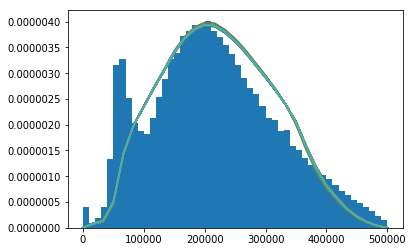

In [19]:
x, y = generate_data()
pred = model.predict_on_batch(x)

plt.figure()
for i in range(100):
    plt.plot(K.eval(x_values)[i, :], pred[i, :])
plt.hist(df.TotalLandImpValue, bins=50, density=True)
plt.plot()
plt.show()

In [14]:
model

In [ ]:
    # Find the left index of the point the sample occurred at.
    loc_mask = K.cast(sample - x[:, :-1] > 0, 'float32') \
                * K.cast(x[:, 1:] - sample >= 0, 'float32')
    
    # Calculate the probability of the sample.
    delta_y = (K.sum(loc_mask * y[:, 1:], axis=1) \
               - K.sum(loc_mask * y[:, :-1], axis=1))
    delta_x = (K.sum(loc_mask * x[:, 1:], axis=1) \
               - K.sum(loc_mask * x[:, :-1], axis=1))
    delta_x = K.maximum(delta_x, 1)

    slope = delta_y / delta_x

    p = K.sum(loc_mask * y[:, :-1], axis=1) \
        + slope * (sample - K.sum(loc_mask * x[:, :-1], axis=1))
    p = K.maximum(p, p_min)